## Goal: Check various hypothesis

In [ ]:
import pandas as pd
import pypsa
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde"

### Check 1: Compare Total System Cost with / without network

In [ ]:
# Total system cost
runs = ["h2network_true", "h2network_false", "test_subworkflow"]

stats = pd.DataFrame(columns=runs, index=["H2", "AC", "total costs"])

for run in runs:
    metrics = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/metrics.csv", header=[0,1,2,3,4,5,6], index_col=0)
    prices = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/prices.csv", header=[0,1,2,3,4,5,6], index_col=0)

    stats.loc["H2", run] = prices.loc["H2"].values[0]
    stats.loc["AC", run] = prices.loc["AC"].values[0]
    stats.loc["total costs", run] = metrics.loc["total costs"].values[0]/1e9 # in B€


In [ ]:
stats.head()

### Check 2: Hydrogen & battery storage of single run but e_inital modification

In [212]:
run = "h2network_true_3h"

In [255]:
networks = ["export_only_einitial", "export_only", "mar_only", "mar_es_export"]

network_paths = {
        "export_only_einitial": prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc",
        "export_only": prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc",
        "mar_only": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc",
        "mar_es_export": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc",
}

Compare system costs of single run with and without e_initial

In [222]:
# Get storage sizes of hydrogen and battery for both networks
stats = pd.DataFrame(columns=networks, index=["H2_GWh", "Battery_GWh", "H2export_GWh", "objective_B€"])

for network in networks:
    
    n = pypsa.Network(network_paths[network])

    stats.loc["H2_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", network] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["H2export_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["objective_B€", network] = n.objective / 1e9 # in B€

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [223]:
stats.head()

,export_only_einitial,export_only,mar_only,mar_es_export
H2_GWh,162.062812,0.0,41.547989,0.918651
Battery_GWh,0.0,0.0,60.808554,59.646081
H2export_GWh,3325.762864,5982.191804,835901.099816,1203587.181138
objective_B€,8.062726,6.588199,11.231884,17.451733


In [ ]:
def get_export_supply(n):
    return (n.links_t.p1.loc[:, n.links_t.p1.columns.str.contains("export")].sum(axis=1)*(-1))


Compare storage parameters of single run with and without e_initial

In [260]:
# Compare storage parameters
def compare_storage_parameters(n1, n2, carrier, export=False):

    if export:
        store1 = n1.stores[(n1.stores.carrier=="H2") & (n1.stores.bus == "H2 export bus")].iloc[0, :]
        store2 = n2.stores[(n2.stores.carrier=="H2") & (n2.stores.bus == "H2 export bus")].iloc[0, :]

    elif export == False:
        store1 = n1.stores[(n1.stores.carrier==carrier) & (n1.stores.bus != "H2 export bus")].iloc[0, :]
        store2 = n2.stores[(n2.stores.carrier==carrier) & (n2.stores.bus != "H2 export bus")].iloc[0, :]

    return pd.concat([store1, store2], axis=1)

In [257]:
n_export_only = pypsa.Network(network_paths["export_only"])
n_export_only_einitial = pypsa.Network(network_paths["export_only_einitial"])

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [280]:
h2exportstore = compare_storage_parameters(n_export_only, n_export_only_einitial, "H2", export=True)

In [281]:
h2exportstore

,H2 export store,H2 export store
bus,H2 export bus,H2 export bus
capital_cost,0.0,0.0
carrier,H2,H2
e_cyclic,True,False
e_nom_extendable,True,True
lifetime,inf,inf
marginal_cost,0.009082,0.009082
e_nom_opt,5982191.803531,3325762.864387
type,,
e_nom,0.0,0.0


Plot time series of single run with and without e_initial

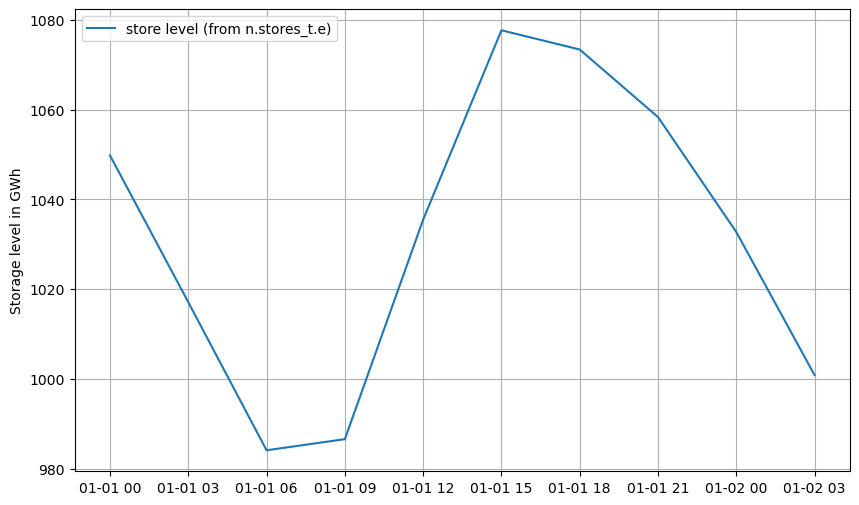

In [272]:
plot_export_store_level(n_export_only, 0, 10)

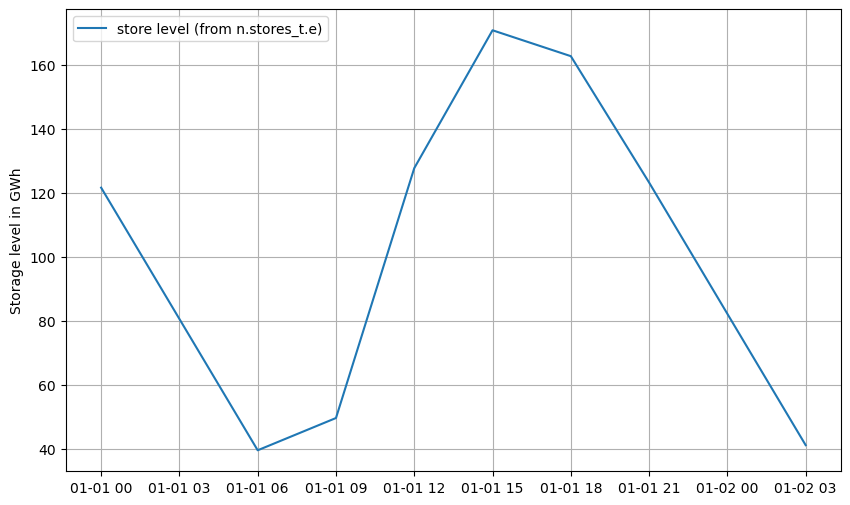

In [273]:
plot_export_store_level(n_export_only_einitial, 0, 10)

In [ ]:
# Show storage levels and charging of 200 time steps
n_old.stores_t.e["H2 export store"].plot() #[2000:2200].plot()
n_new.stores_t.e["H2 export store"].plot() #[2000:2200].plot()

export_supply_new = get_export_supply(n_new)

In [ ]:
#export_supply_old[2000:2400].plot()
export_supply_new[2000:2400].plot()

In [ ]:
n_old.objective/1e6

In [ ]:
n_new.objective/1e6

In [ ]:
n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.stores[n.stores.index.str.contains("battery")].head()

In [ ]:
n.generators.p_nom_opt.sort_values(ascending=False)[0:10]

In [ ]:
n.links_t.p0.loc[:, n.links.index.str.contains("battery")].sum().sort_values(ascending=False)[0:10] #.head()

In [ ]:
# Show capacities and nodes of top batteries
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sort_values(ascending=False) # head()

Export hydrogen storage

In [ ]:
n.stores[n.stores.bus == "H2 export bus"].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.loads

In [195]:
# Show storage levels and charging of 200 time steps
import matplotlib.pyplot as plt
def plot_export_store(n, time_min = 0, time_max = 10):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()

    ax.plot(n.stores_t.p["H2 export store"][time_min:time_max]/1e3) # in GW
    ax.plot(n.loads_t.p["H2 export load"][time_min:time_max]/1e3) # in GW
    ax.plot(get_export_supply(n)[time_min:time_max]/1e3) # in GW

    storage_level = n.stores_t.e["H2 export store"][time_min:time_max]/ 1e3 # in GWh
    ax2.plot(storage_level, color="grey", linestyle="--")

    ax.legend(["store charging", "export load", "supply (from system)"], loc='upper right')
    ax2.legend(["store level (from n.stores_t.e)"], loc='upper left')
    ax2.set_ylabel("Storage level in GWh")
    ax.set_ylabel("Power in GW")
    ax.grid()

def plot_export_store_level(n, time_min = 0, time_max = 10):


    fig, ax = plt.subplots(figsize=(10, 6))
    storage_level = n.stores_t.e["H2 export store"][time_min:time_max]/ 1e3 # in GWh

    ax.plot(storage_level)
    ax.legend(["store level (from n.stores_t.e)"], loc='upper left')
    ax.set_ylabel("Storage level in GWh")
    ax.grid()

In [ ]:
plot_export_store_level(n, 0, 1600)

In [ ]:
plot_export_store(n, 0, 160)

### Check 3: Battery storage in export only

Retrieve storage sizes across types (MAR ES only, MAR ES export, Export only) within one scenario/run

In [190]:
# Get storage sizes of hydrogen and battery for all networks
run = "store_standardcosts_6h_ws"
networks = ["export_only", "mar_only", "mar_es_export"]

network_paths = {
        "export_only": prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export_solved.nc",
        "mar_only": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_0export.nc",
        "mar_es_export": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc",
}


stats = pd.DataFrame(columns=networks, index=["H2_GWh", "Battery_GWh", "H2export_GWh"])

for network in networks:
    
    n = pypsa.Network(network_paths[network])

    stats.loc["H2_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", network] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

    stats.loc["H2export_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [191]:
stats.head()

,export_only,mar_only,mar_es_export
H2_GWh,-0.0,61.145433,161.574785
Battery_GWh,7212.478374,53.894214,48.441827
H2export_GWh,0.0,0.000157,21.335936


Compare parameters of battery storage in export only and MAR ES export

In [196]:
networks = ["export_only", "mar_only", "mar_es_export"]
n_export_only = pypsa.Network(network_paths[networks[0]])
n_mar_es_export = pypsa.Network(network_paths[networks[2]])

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [243]:
batteries = compare_storage_parameters(n_export_only, n_mar_es_export, "battery", export=False)

In [244]:
batteries

,MA.1.1_1_AC battery,MA.1.1_1_AC battery
bus,MA.1.1_1_AC battery,MA.1.1_1_AC battery
capital_cost,12295.064307,12295.064307
carrier,battery,battery
e_cyclic,True,True
e_nom_extendable,True,True
lifetime,25.0,25.0
marginal_cost,0.009965,0.009965
e_nom_opt,0.0,2.636986
type,,
e_nom,0.0,0.0


Compare timeseries of battery storage in export only and MAR ES export

In [ ]:
plot_export_store_level(n_export_only, 0, 160)
plot_export_store_level(n_mar_es_export, 0, 160)

### Check 4: Export store with costs/no costs/no store

Define runs/scenarios to compare

In [187]:
runs = ["store_nocosts_6h_ws", "store_standardcosts_6h_ws", "store_nostore_6h_ws"]

Retrieve storage sizes of one type (MAR ES export) of various scenarios/runs

In [188]:
# Get storage sizes of hydrogen and battery for all networks
stats = pd.DataFrame(columns=runs, index=["H2_GWh", "Battery_GWh", "H2export_GWh", "objective_B€"])

for run in runs:
    
    network_path = prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc"

    n = pypsa.Network(network_path)

    stats.loc["H2_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", run] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["H2export_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["objective_B€", run] = n.objective / 1e9 # in B€

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [189]:
stats.head()

,store_nocosts_6h_ws,store_standardcosts_6h_ws,store_nostore_6h_ws
H2_GWh,30.14973,161.574785,182.908774
Battery_GWh,47.387106,48.441827,48.437268
H2export_GWh,8683.058316,21.335936,0.0
objective_B€,17.078372,18.133305,18.133065


Show timeseries of single run/scenario

In [160]:
run = ["store_nocosts_6h_ws", "store_standardcosts_6h_ws", "store_nostore_6h_ws"]
network_path = prefix + "/resources/pypsaearthsec/" + run[1] + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc"
n = pypsa.Network(network_path)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [ ]:
export_supply = get_export_supply(n)
export_supply[0:600].plot()

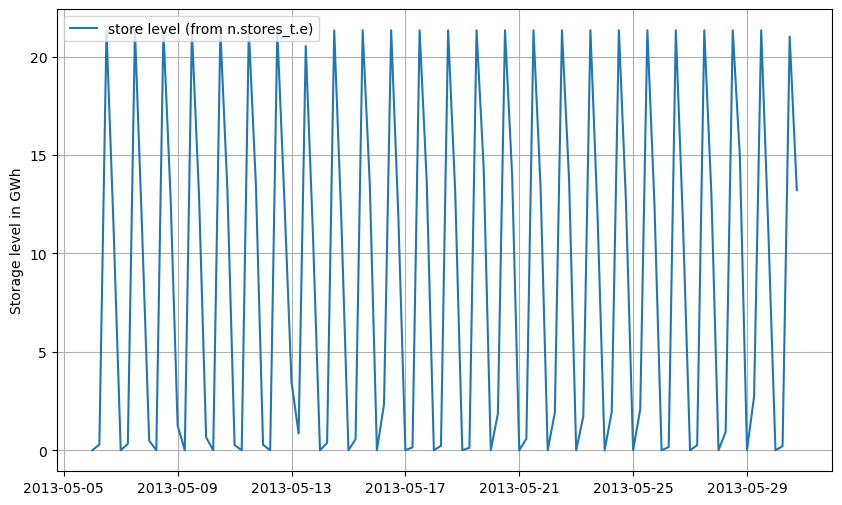

In [193]:
plot_export_store_level(n, 500, 600)

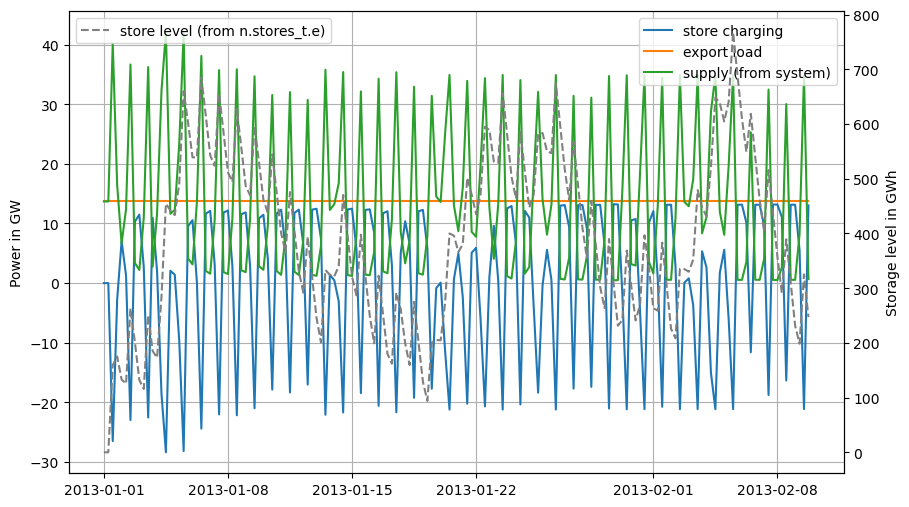

In [142]:
plot_export_store(n, 0, 160)